In [1]:
!pip install git+https://github.com/kazewong/jim
#!pip install jimGW

  Cloning https://github.com/kazewong/jim to /tmp/pip-req-build-mfdm7s5g
  Running command git clone --filter=blob:none --quiet https://github.com/kazewong/jim /tmp/pip-req-build-mfdm7s5g
  Resolved https://github.com/kazewong/jim to commit 03842792626c3a14ec8885f8076833324c391db2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flowmc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of equinox to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of evosax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of flax to determine which version is compatible with other requiremen

In [2]:
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.0/698.0 MB 2.8 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.5.1
    Uninstalling jax-cuda12-pjrt-0.5.1:
      Successfully uninstalled jax-cuda12-pjrt-0.5.1
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.3.0.75
    Uninstalling nvidia-cudnn-cu12-9.3.0.75:
      Successfully uninstalled

In [3]:
!pip install --upgrade equinox

  Using cached equinox-0.12.1-py3-none-any.whl.metadata (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: equinox
    Found existing installation: equinox 0.11.10
    Uninstalling equinox-0.11.10:
      Successfully uninstalled equinox-0.11.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jimgw 0.2.0 requires jax<=0.4.31,>=0.4.24, but you have jax 0.6.0 which is incompatible.


In [4]:
import numpy as np
import jax.numpy as jnp

In [5]:
import time

import jax
import jax.numpy as jnp

from jimgw.jim import Jim
#from jimgw.jim import Jim
from jimgw.prior import (
    CombinePrior,
    UniformPrior,
    CosinePrior,
    SinePrior,
    PowerLawPrior,
    UniformSpherePrior,
)
from jimgw.single_event.detector import H1, L1, V1
from jimgw.single_event.likelihood import TransientLikelihoodFD, HeterodynedTransientLikelihoodFD
from jimgw.single_event.waveform import RippleIMRPhenomD,RippleIMRPhenomD_NRTidalv2,RippleTaylorF2
from jimgw.transforms import BoundToUnbound
from jimgw.single_event.transforms import (
    SkyFrameToDetectorFrameSkyPositionTransform,
    SphereSpinToCartesianSpinTransform,
    MassRatioToSymmetricMassRatioTransform,
    DistanceToSNRWeightedDistanceTransform,
    GeocentricArrivalTimeToDetectorArrivalTimeTransform,
    GeocentricArrivalPhaseToDetectorArrivalPhaseTransform,
)
from jimgw.single_event.utils import Mc_q_to_m1_m2
from flowMC.strategy.optimization import optimization_Adam

jax.config.update("jax_enable_x64", True)

###########################################
########## First we grab data #############
###########################################

total_time_start = time.time()

# first, fetch a 4s segment centered on GW150914

ifos = [H1, L1, V1]


# tukey_alpha = 2 / (duration / 2)
# H1.load_data(
#     gps, duration, 2, fmin, fmax, psd_pad=duration + 16, tukey_alpha=tukey_alpha
# )
# L1.load_data(
#     gps, duration, 2, fmin, fmax, psd_pad=duration + 16, tukey_alpha=tukey_alpha
# )
# V1.load_data(
#     gps, duration, 2, fmin, fmax, psd_pad=duration + 16, tukey_alpha=tukey_alpha
# )

H1.frequencies = np.genfromtxt('H1_freq.txt')
H1_data_re, H1_data_im = np.genfromtxt('H1_data_re.txt'), np.genfromtxt('H1_data_im.txt')
H1.data = H1_data_re + 1j * H1_data_im
H1_jnp = jax.numpy.array(H1.frequencies)

L1.frequencies = np.genfromtxt('L1_freq.txt')
L1_data_re, L1_data_im = np.genfromtxt('L1_data_re.txt'), np.genfromtxt('L1_data_im.txt')
L1.data = L1_data_re + 1j * L1_data_im
L1_jnp = jax.numpy.array(L1.frequencies)

V1.frequencies = np.genfromtxt('V1_freq.txt')
V1_data_re, V1_data_im = np.genfromtxt('V1_data_re.txt'), np.genfromtxt('V1_data_im.txt')
V1.data = V1_data_re + 1j * V1_data_im
V1_jnp = jax.numpy.array(V1.frequencies)
# Load the PSD

H1.psd = H1.load_psd(H1_jnp, psd_file ="GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_H1_psd.txt")
L1.psd = L1.load_psd(L1_jnp, psd_file = "GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_L1_psd.txt")
V1.psd = V1.load_psd(V1_jnp, psd_file = "GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_V1_psd.txt")





In [6]:
len(H1.psd),min(H1.frequencies)

(259583, np.float64(20.0078125))

In [7]:
import numpy as np

# H1 frequency masking
ah = H1.frequencies
bh = H1.data
ch = H1.psd

# Find the indices where any of the arrays contains inf
mask = np.isinf(ah) | np.isinf(bh) | np.isinf(ch)

# Remove the elements where the mask is True
H1.frequencies = ah[~mask][:-1]
H1.data = bh[~mask][:-1]
H1.psd = ch[~mask][:-1]



# L1 frequency masking
aL = L1.frequencies
bL = L1.data
cL = L1.psd

# Find the indices where any of the arrays contains inf
mask = np.isinf(aL) | np.isinf(bL) | np.isinf(cL)

# Remove the elements where the mask is True
L1.frequencies = aL[~mask]
L1.data = bL[~mask]
L1.psd = cL[~mask]


# V1 frequency masking
aV = V1.frequencies
bV = V1.data
cV = V1.psd

# Find the indices where any of the arrays contains inf
mask = np.isinf(aV) | np.isinf(bV) | np.isinf(cV)

# Remove the elements where the mask is True
V1.frequencies = aV[~mask]
V1.data = bV[~mask]
V1.psd = cV[~mask]





gps = 1187008882.43
trigger_time = gps
fmin = min(H1.frequencies)
fmax = max(H1.frequencies)
#fmax = 2048
minimum_frequency = fmin
maximum_frequency = fmax
duration = 128
post_trigger_duration = 2
epoch = duration - post_trigger_duration
f_ref = fmin

waveform = RippleIMRPhenomD(f_ref=f_ref)
#RippleIMRPhenomD_NRTidalv2(f_ref=f_ref)


In [8]:
len(H1.data),len(H1.psd),len(H1.frequencies),len(L1.psd),len(L1.frequencies),len(V1.psd),len(V1.frequencies)

(259199, 259199, 259199, 259199, 259199, 259199, 259199)

In [9]:
min(H1.frequencies),min(L1.frequencies),min(V1.frequencies),max(H1.frequencies),max(L1.frequencies),max(V1.frequencies)

(np.float64(23.0),
 np.float64(23.0),
 np.float64(23.0),
 np.float64(2047.984375),
 np.float64(2047.984375),
 np.float64(2047.984375))

In [10]:
fmin,fmax

(np.float64(23.0), np.float64(2047.984375))

In [11]:
import numpy as np

# Example array


# Check if there are any inf values in a
contains_inf = np.any(np.isinf(H1.psd))

if contains_inf:
    print("Array contains inf values.")
else:
    print("Array does not contain inf values.")


Array does not contain inf values.


In [12]:
###########################################
########## Set up priors ##################
###########################################

prior = []

# Mass prior
M_c_min, M_c_max = 1.18, 1.21
q_min, q_max = 0.125, 1.0
Mc_prior = UniformPrior(M_c_min, M_c_max, parameter_names=["M_c"])
q_prior = UniformPrior(q_min, q_max, parameter_names=["q"])

prior = prior + [Mc_prior, q_prior]

# Spin prior
s1_prior = UniformPrior(-0.05, 0.05, parameter_names=["s1_z"])
s2_prior = UniformPrior(-0.05, 0.05, parameter_names=["s2_z"])
iota_prior = SinePrior(parameter_names=["iota"])

prior = prior + [
    s1_prior,
    s2_prior,
    iota_prior,
]

# Extrinsic prior
dL_prior = UniformPrior(1.0, 75.0, parameter_names=["d_L"])
t_c_prior = UniformPrior(-0.1, 0.1, parameter_names=["t_c"])
phase_c_prior = UniformPrior(0.0, 2 * jnp.pi, parameter_names=["phase_c"])
#lambda_1_prior =UniformPrior(0.0, 5000.0, parameter_names=["lambda_1"])
#lambda_2_prior = UniformPrior(0.0, 5000.0, parameter_names=["lambda_2"])
psi_prior = UniformPrior(0.0, jnp.pi, parameter_names=["psi"])
ra_prior = UniformPrior(0.0, 2 * jnp.pi, parameter_names=["ra"])
dec_prior =CosinePrior(parameter_names=["dec"])

prior = prior + [
    dL_prior,
    t_c_prior,
    phase_c_prior,
   #lambda_1_prior,
   #lambda_2_prior,
    psi_prior,
    ra_prior,
    dec_prior,
]

prior = CombinePrior(prior)

# The following only works if every prior has xmin and xmax property, which is OK for Uniform and Powerlaw
# bounds = jnp.array([[p.xmin, p.xmax] for p in prior.priors])

# Defining Transforms

sample_transforms = [
    DistanceToSNRWeightedDistanceTransform(gps_time=gps, ifos=ifos, dL_min=dL_prior.xmin, dL_max=dL_prior.xmax),
    GeocentricArrivalPhaseToDetectorArrivalPhaseTransform(gps_time=gps, ifo=ifos[0]),
    GeocentricArrivalTimeToDetectorArrivalTimeTransform(tc_min=t_c_prior.xmin, tc_max=t_c_prior.xmax, gps_time=gps, ifo=ifos[0]),
    SkyFrameToDetectorFrameSkyPositionTransform(gps_time=gps, ifos=ifos),
    BoundToUnbound(name_mapping = (["M_c"], ["M_c_unbounded"]), original_lower_bound=M_c_min, original_upper_bound=M_c_max),
    BoundToUnbound(name_mapping = (["q"], ["q_unbounded"]), original_lower_bound=q_min, original_upper_bound=q_max),
    #BoundToUnbound(name_mapping = (["lambda_1"], ["lambda_1_unbounded"]), original_lower_bound=0.0, original_upper_bound=5000.0),
    #BoundToUnbound(name_mapping = (["lambda_2"], ["lambda_2_unbounded"]), original_lower_bound=0.0, original_upper_bound=5000.0),
    BoundToUnbound(name_mapping = (["s1_z"], ["s1_z_unbounded"]) , original_lower_bound=-0.05, original_upper_bound=0.05),
    BoundToUnbound(name_mapping = (["s2_z"], ["s2_z_unbounded"]) , original_lower_bound=-0.05, original_upper_bound=0.05),
    BoundToUnbound(name_mapping = (["iota"], ["iota_unbounded"]) , original_lower_bound=0.0, original_upper_bound=jnp.pi),
    BoundToUnbound(name_mapping = (["phase_det"], ["phase_det_unbounded"]), original_lower_bound=0.0, original_upper_bound=2 * jnp.pi),
    BoundToUnbound(name_mapping = (["psi"], ["psi_unbounded"]), original_lower_bound=0.0, original_upper_bound=jnp.pi),
    BoundToUnbound(name_mapping = (["zenith"], ["zenith_unbounded"]), original_lower_bound=0.0, original_upper_bound=jnp.pi),
    BoundToUnbound(name_mapping = (["azimuth"], ["azimuth_unbounded"]), original_lower_bound=0.0, original_upper_bound=2 * jnp.pi),
]

likelihood_transforms = [
    MassRatioToSymmetricMassRatioTransform,
]


#likelihood = TransientLikelihoodFD(
#    [H1, L1, V1], waveform=waveform, trigger_time=trigger_time, duration=duration, post_trigger_duration=post_trigger_duration
#)
ref_params = {
   'M_c': 1.1975896,
   'eta': 0.2461001,
   's1_z': -2.96672676e-02,
   's2_z': 2.80404568e-02,
   #'lambda_1': 791.04366468,
   #'lambda_2': 891.04366468,
   'd_L': 42.86331818,
   't_c': -5.93548230e-05,
   'phase_c': 4.58680356e+00,
   'iota': 2.85,
   'psi': 3.14,
   'ra': 3.44536826,
   'dec': -0.408082
}

likelihood = HeterodynedTransientLikelihoodFD(ifos, waveform=waveform,ref_params=ref_params, n_bins = 1000, trigger_time=trigger_time, duration=duration, post_trigger_duration=post_trigger_duration, prior = prior, sample_transforms = sample_transforms, likelihood_transforms = likelihood_transforms, popsize = 500, n_steps = 5000)

eps = 1e-3
n_dim = 11 #13
mass_matrix = jnp.eye(n_dim)
#mass_matrix = mass_matrix.at[0,0].set(1e-5)
#mass_matrix = mass_matrix.at[1,1].set(1e-4)
#mass_matrix = mass_matrix.at[2,2].set(1e-3)
#mass_matrix = mass_matrix.at[3,3].set(1e-3)
#mass_matrix = mass_matrix.at[5,5].set(1e-5) #mass_matrix = mass_matrix.at[7,7].set(1e-5)
#mass_matrix = mass_matrix.at[9,9].set(1e-2)#mass_matrix = mass_matrix.at[11,11].set(1e-2)
#mass_matrix = mass_matrix.at[10,10].set(1e-2)#mass_matrix = mass_matrix.at[12,12].set(1e-2)
local_sampler_arg = {"step_size": mass_matrix * eps}

Adam_optimizer = optimization_Adam(n_steps=3000, learning_rate=0.01, noise_level=1)

import optax

n_loop_training = 50
n_epochs = 20
total_epochs = n_epochs * n_loop_training
start = int(total_epochs / 10)
start_lr = 1e-3
end_lr = 1e-5
power = 4.0
schedule_fn = optax.polynomial_schedule(
    start_lr, end_lr, power, total_epochs-start, transition_begin=start)

scheduler_str = f"polynomial_schedule({start_lr}, {end_lr}, {power}, {total_epochs-start}, {start})"

# Choose between fixed learning rate - or - the above scheduler here

# learning_rate = 1e-3
learning_rate = schedule_fn

jim = Jim(
    likelihood,
    prior,
    sample_transforms=sample_transforms,
    likelihood_transforms=likelihood_transforms,
    n_loop_training=n_loop_training,
    n_loop_production=20,
    n_local_steps=100,
    n_global_steps=500,
    n_chains=1000,
    n_epochs =n_epochs,
    learning_rate=learning_rate,
    n_max_examples=30000,
    n_flow_sample=50000,
    momentum=0.9,
    batch_size=50000,
    use_global=True,
    keep_quantile=0.0,
    train_thinning=50,
    output_thinning=50,
    local_sampler_arg=local_sampler_arg,
    stopping_criterion_global_acc = 0.2
    #strategies=[Adam_optimizer,"default"],
)


jim.sample(jax.random.PRNGKey(4123578))
jim.print_summary()

Initializing heterodyned likelihood..
Reference parameters provided, which are {'M_c': 1.1975896, 'eta': 0.2461001, 's1_z': -0.0296672676, 's2_z': 0.0280404568, 'd_L': 42.86331818, 't_c': -5.9354823e-05, 'phase_c': 4.58680356, 'iota': 2.85, 'psi': 3.14, 'ra': 3.44536826, 'dec': -0.408082}
Constructing reference waveforms..
Using sample transforms
['n_dim', 'n_chains', 'n_local_steps', 'n_global_steps', 'n_loop', 'output_thinning', 'verbose']


Global Tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Compiling MALA body


Global Sampling: 100%|██████████| 20/20 [16:18<00:00, 48.93s/it]


Training summary
M_c: 1.197 +/- 0.001
d_L: 49.455 +/- 12.636
dec: -0.187 +/- 0.481
iota: 2.131 +/- 0.855
phase_c: 3.222 +/- 1.874
psi: 1.823 +/- 0.894
q: 0.733 +/- 0.166
ra: 3.263 +/- 0.970
s1_z: 0.001 +/- 0.025
s2_z: 0.006 +/- 0.026
t_c: 0.005 +/- 0.015
Log probability: 338.344 +/- 1728.882
Local acceptance: 0.353 +/- 0.478
Global acceptance: 0.001 +/- 0.038
Max loss: 22.517, Min loss: 7.791
Production summary
M_c: 1.197 +/- 0.000
d_L: 41.988 +/- 5.844
dec: -0.361 +/- 0.087
iota: 2.697 +/- 0.311
phase_c: 3.279 +/- 1.955
psi: 1.896 +/- 0.891
q: 0.764 +/- 0.087
ra: 3.429 +/- 0.053
s1_z: 0.000 +/- 0.021
s2_z: 0.013 +/- 0.021
t_c: 0.000 +/- 0.001
Log probability: 521.149 +/- 7.075
Local acceptance: 0.152 +/- 0.359
Global acceptance: 0.000 +/- 0.010


In [ ]:
# M_c: 1.197 +/- 0.000
# d_L: 41.988 +/- 5.844
# dec: -0.361 +/- 0.087
# iota: 2.697 +/- 0.311
# phase_c: 3.279 +/- 1.955
# psi: 1.896 +/- 0.891
# q: 0.764 +/- 0.087
# ra: 3.429 +/- 0.053
# s1_z: 0.000 +/- 0.021
# s2_z: 0.013 +/- 0.021
# t_c: 0.000 +/- 0.001
# Log probability: 521.149 +/- 7.075
# Local acceptance: 0.152 +/- 0.359
# Global acceptance: 0.000 +/- 0.010

In [13]:
# 1st run :
#M_c: 1.198 +/- 0.000
# d_L: 42.055 +/- 6.518
# dec: -0.347 +/- 0.196
# iota: 2.453 +/- 0.618
# phase_c: 3.188 +/- 1.741
# psi: 1.406 +/- 0.835
# q: 0.762 +/- 0.066
# ra: 3.414 +/- 0.263
# s1_z: 0.015 +/- 0.021
# s2_z: -0.005 +/- 0.019
# t_c: 0.001 +/- 0.004
# Log probability: 509.006 +/- 10.833
# Local acceptance: 0.162 +/- 0.369
# Global acceptance: 0.000 +/- 0.005


In [14]:
# 2nd run :
# M_c: 1.198 +/- 0.000
# d_L: 40.544 +/- 5.429
# dec: -0.422 +/- 0.098
# iota: 2.558 +/- 0.304
# phase_c: 2.983 +/- 1.695
# psi: 1.324 +/- 0.836
# q: 0.734 +/- 0.078
# ra: 3.469 +/- 0.071
# s1_z: 0.007 +/- 0.020
# s2_z: 0.017 +/- 0.021
# t_c: -0.000 +/- 0.001
# Log probability: 520.088 +/- 6.460
# Local acceptance: 0.155 +/- 0.362
# Global acceptance: 0.000 +/- 0.005

In [15]:
import numpy as np
#import corner
samples = jim.get_samples()
DL = np.array(samples["d_L"])
np.median(DL),np.std(DL)

(np.float64(42.56597365113842), np.float64(5.844031083197229))

In [16]:
import pandas as pd

df = pd.DataFrame(samples)

# Save the DataFrame to a CSV file
df.to_csv('GW170817_GR_11_PARAM_manual_data_with_psd.csv', index=False)

<ipython-input-17-351450604c2d>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(DL)


<Axes: ylabel='Density'>

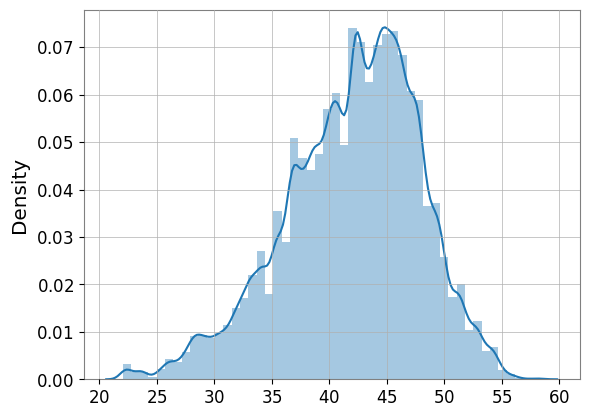

In [17]:
import seaborn as sns
sns.distplot(DL)

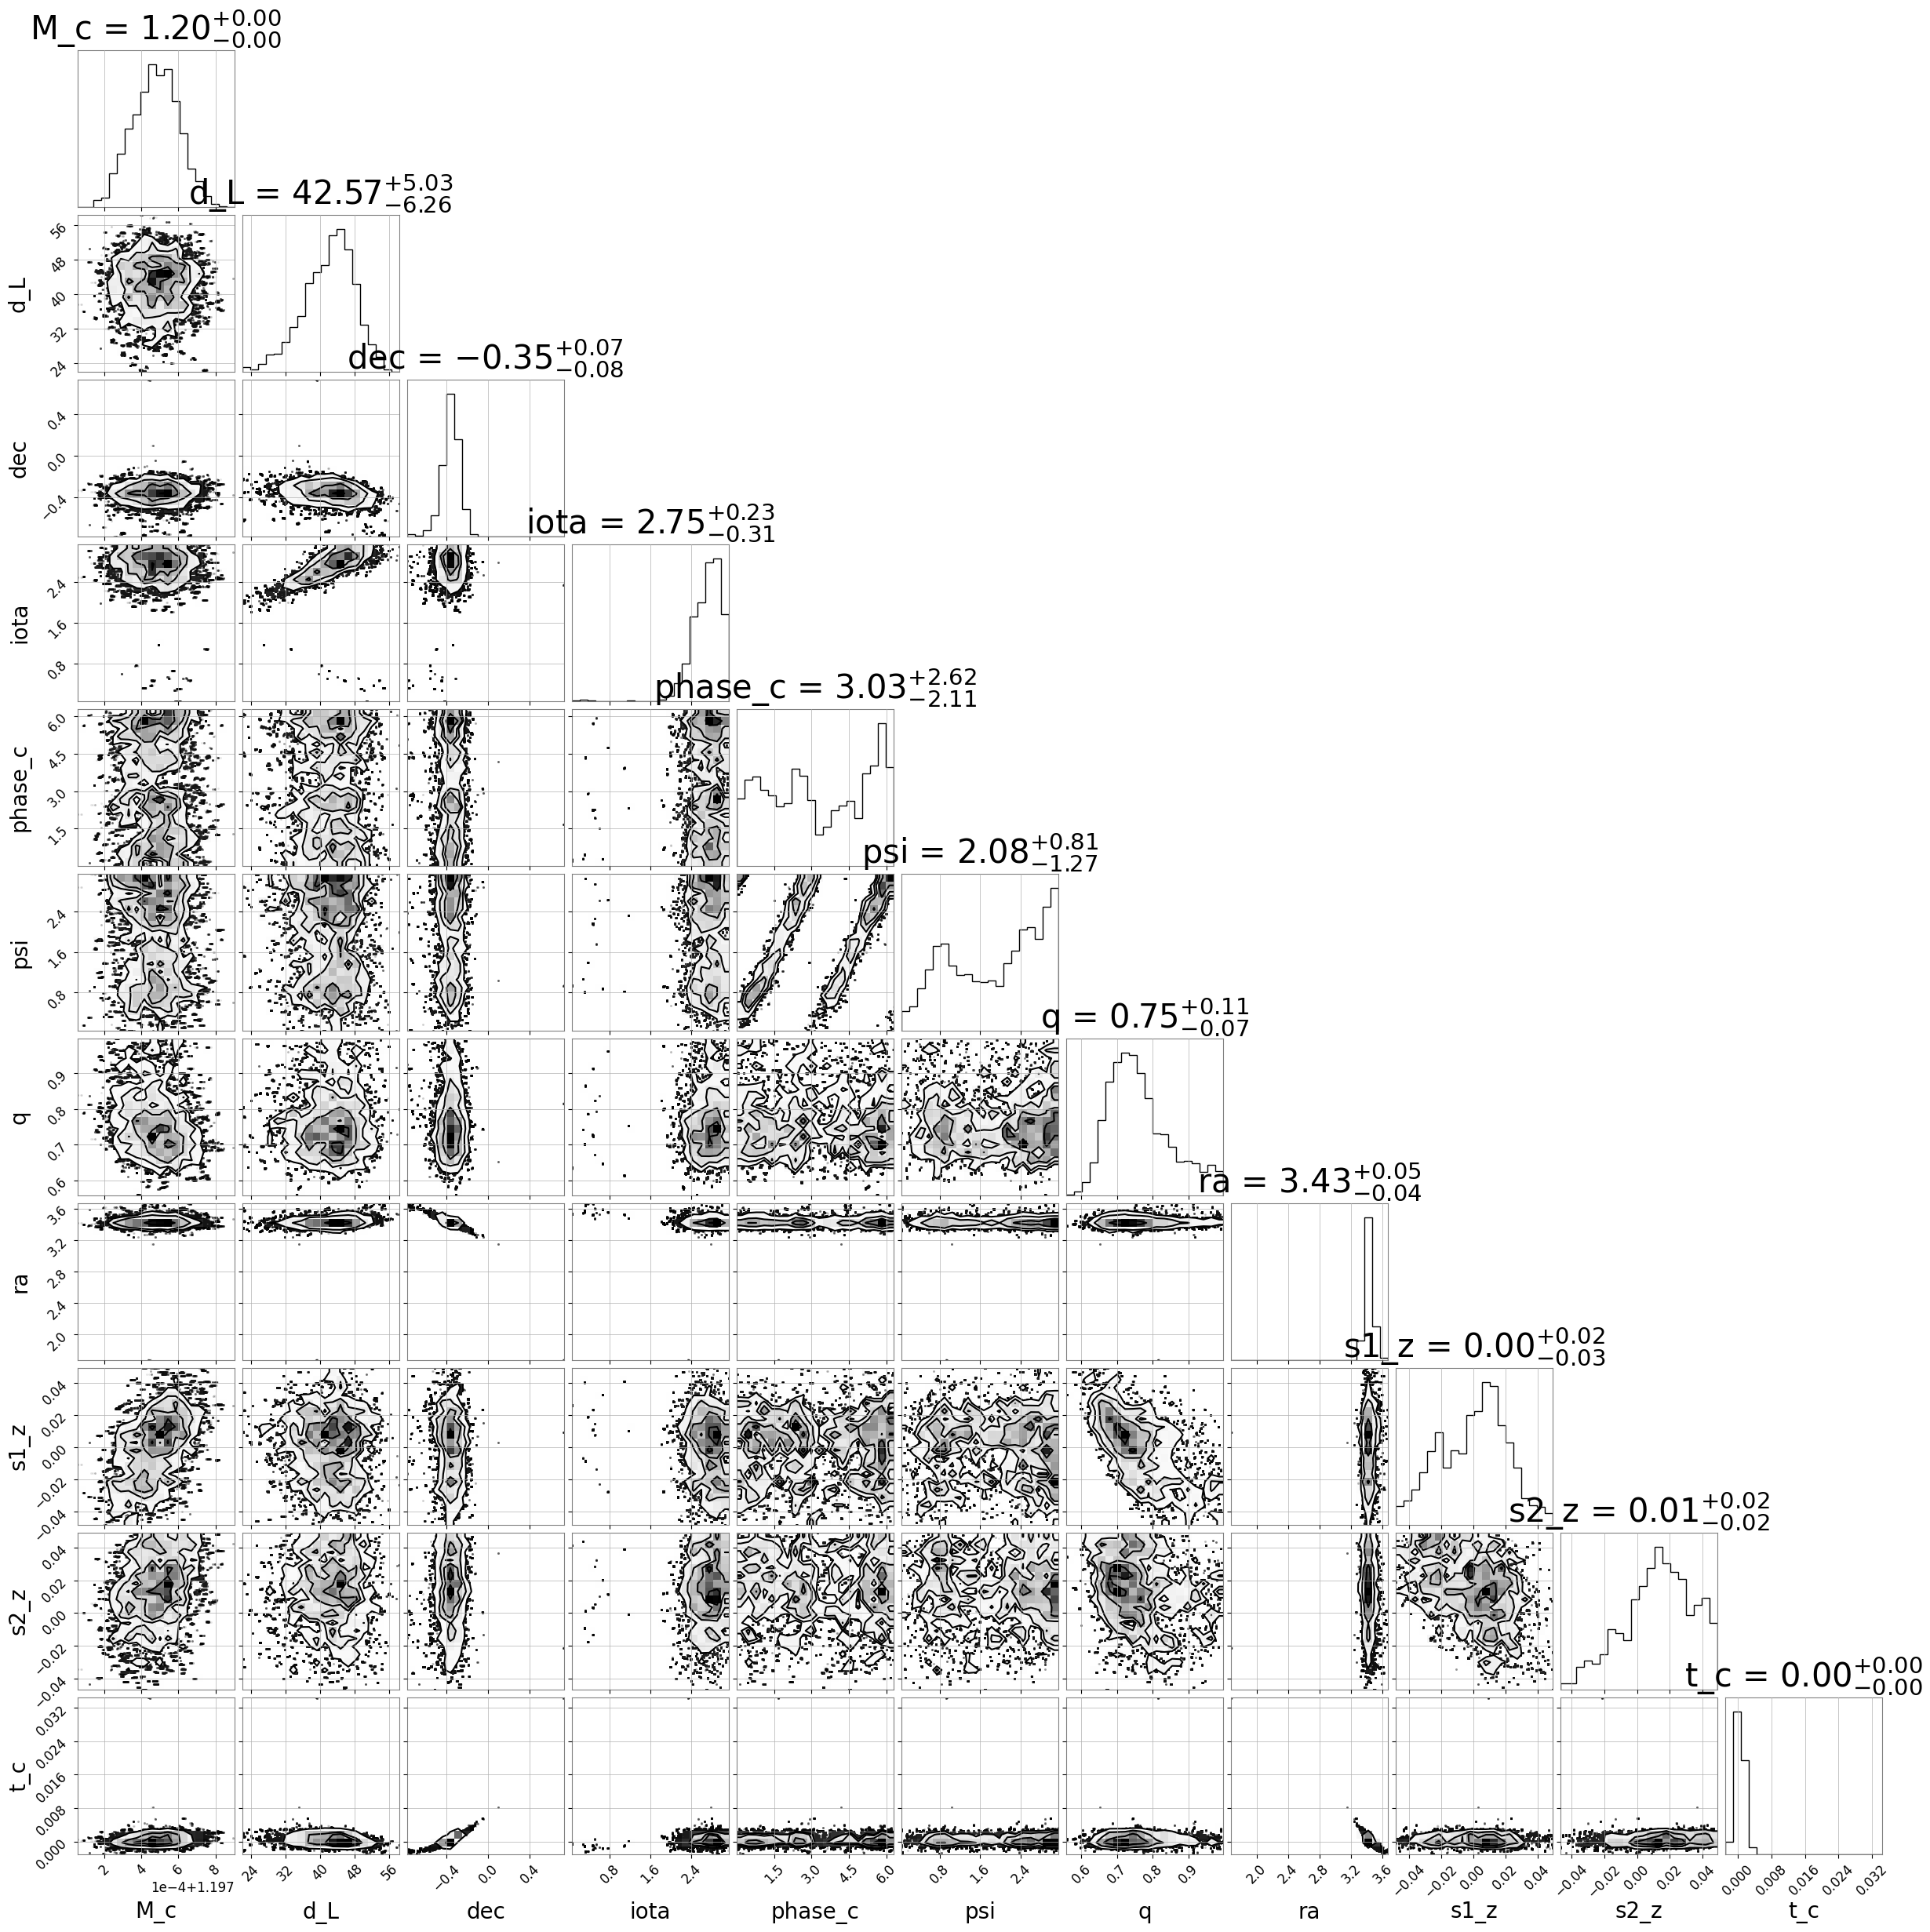

In [18]:
import corner
import numpy as np
import matplotlib.pyplot as plt
data = np.vstack([value for value in samples.values()]).T

# Create corner plot
fig = corner.corner(data, labels=list(samples.keys()),title_kwargs={'fontsize': 30},  # Increase title font size
    label_kwargs={'fontsize': 20}, show_titles=True)
plt.savefig("GW170817_GR_11_PARAM_manual_data_lambda.pdf")
# Show the plot
plt.show()

In [19]:
jim.print_summary()

Training summary
M_c: 1.197 +/- 0.001
d_L: 49.455 +/- 12.636
dec: -0.187 +/- 0.481
iota: 2.131 +/- 0.855
phase_c: 3.222 +/- 1.874
psi: 1.823 +/- 0.894
q: 0.733 +/- 0.166
ra: 3.263 +/- 0.970
s1_z: 0.001 +/- 0.025
s2_z: 0.006 +/- 0.026
t_c: 0.005 +/- 0.015
Log probability: 338.344 +/- 1728.882
Local acceptance: 0.353 +/- 0.478
Global acceptance: 0.001 +/- 0.038
Max loss: 22.517, Min loss: 7.791
Production summary
M_c: 1.197 +/- 0.000
d_L: 41.988 +/- 5.844
dec: -0.361 +/- 0.087
iota: 2.697 +/- 0.311
phase_c: 3.279 +/- 1.955
psi: 1.896 +/- 0.891
q: 0.764 +/- 0.087
ra: 3.429 +/- 0.053
s1_z: 0.000 +/- 0.021
s2_z: 0.013 +/- 0.021
t_c: 0.000 +/- 0.001
Log probability: 521.149 +/- 7.075
Local acceptance: 0.152 +/- 0.359
Global acceptance: 0.000 +/- 0.010


Gelman-Rubin (Rhat) Values:
 <xarray.Dataset> Size: 88B
Dimensions:  ()
Data variables:
    M_c      float64 8B 1.002
    d_L      float64 8B 1.001
    dec      float64 8B 1.001
    iota     float64 8B 1.001
    phase_c  float64 8B 1.001
    psi      float64 8B 1.001
    q        float64 8B 1.003
    ra       float64 8B 1.0
    s1_z     float64 8B 1.001
    s2_z     float64 8B 1.002
    t_c      float64 8B 1.001

Effective Sample Size (ESS):
 <xarray.Dataset> Size: 88B
Dimensions:  ()
Data variables:
    M_c      float64 8B 997.8
    d_L      float64 8B 1.328e+03
    dec      float64 8B 1.269e+03
    iota     float64 8B 1.263e+03
    phase_c  float64 8B 1.385e+03
    psi      float64 8B 1.156e+03
    q        float64 8B 1.263e+03
    ra       float64 8B 1.274e+03
    s1_z     float64 8B 1.233e+03
    s2_z     float64 8B 1.205e+03
    t_c      float64 8B 1.269e+03


array([[<Axes: title={'center': 'M_c\n0'}>,
        <Axes: title={'center': 'M_c\n1'}>,
        <Axes: title={'center': 'd_L\n0'}>,
        <Axes: title={'center': 'd_L\n1'}>],
       [<Axes: title={'center': 'dec\n0'}>,
        <Axes: title={'center': 'dec\n1'}>,
        <Axes: title={'center': 'iota\n0'}>,
        <Axes: title={'center': 'iota\n1'}>],
       [<Axes: title={'center': 'phase_c\n0'}>,
        <Axes: title={'center': 'phase_c\n1'}>,
        <Axes: title={'center': 'psi\n0'}>,
        <Axes: title={'center': 'psi\n1'}>],
       [<Axes: title={'center': 'q\n0'}>,
        <Axes: title={'center': 'q\n1'}>,
        <Axes: title={'center': 'ra\n0'}>,
        <Axes: title={'center': 'ra\n1'}>],
       [<Axes: title={'center': 's1_z\n0'}>,
        <Axes: title={'center': 's1_z\n1'}>,
        <Axes: title={'center': 's2_z\n0'}>,
        <Axes: title={'center': 's2_z\n1'}>],
       [<Axes: title={'center': 't_c\n0'}>,
        <Axes: title={'center': 't_c\n1'}>, <Axes: >, <Axes: >]

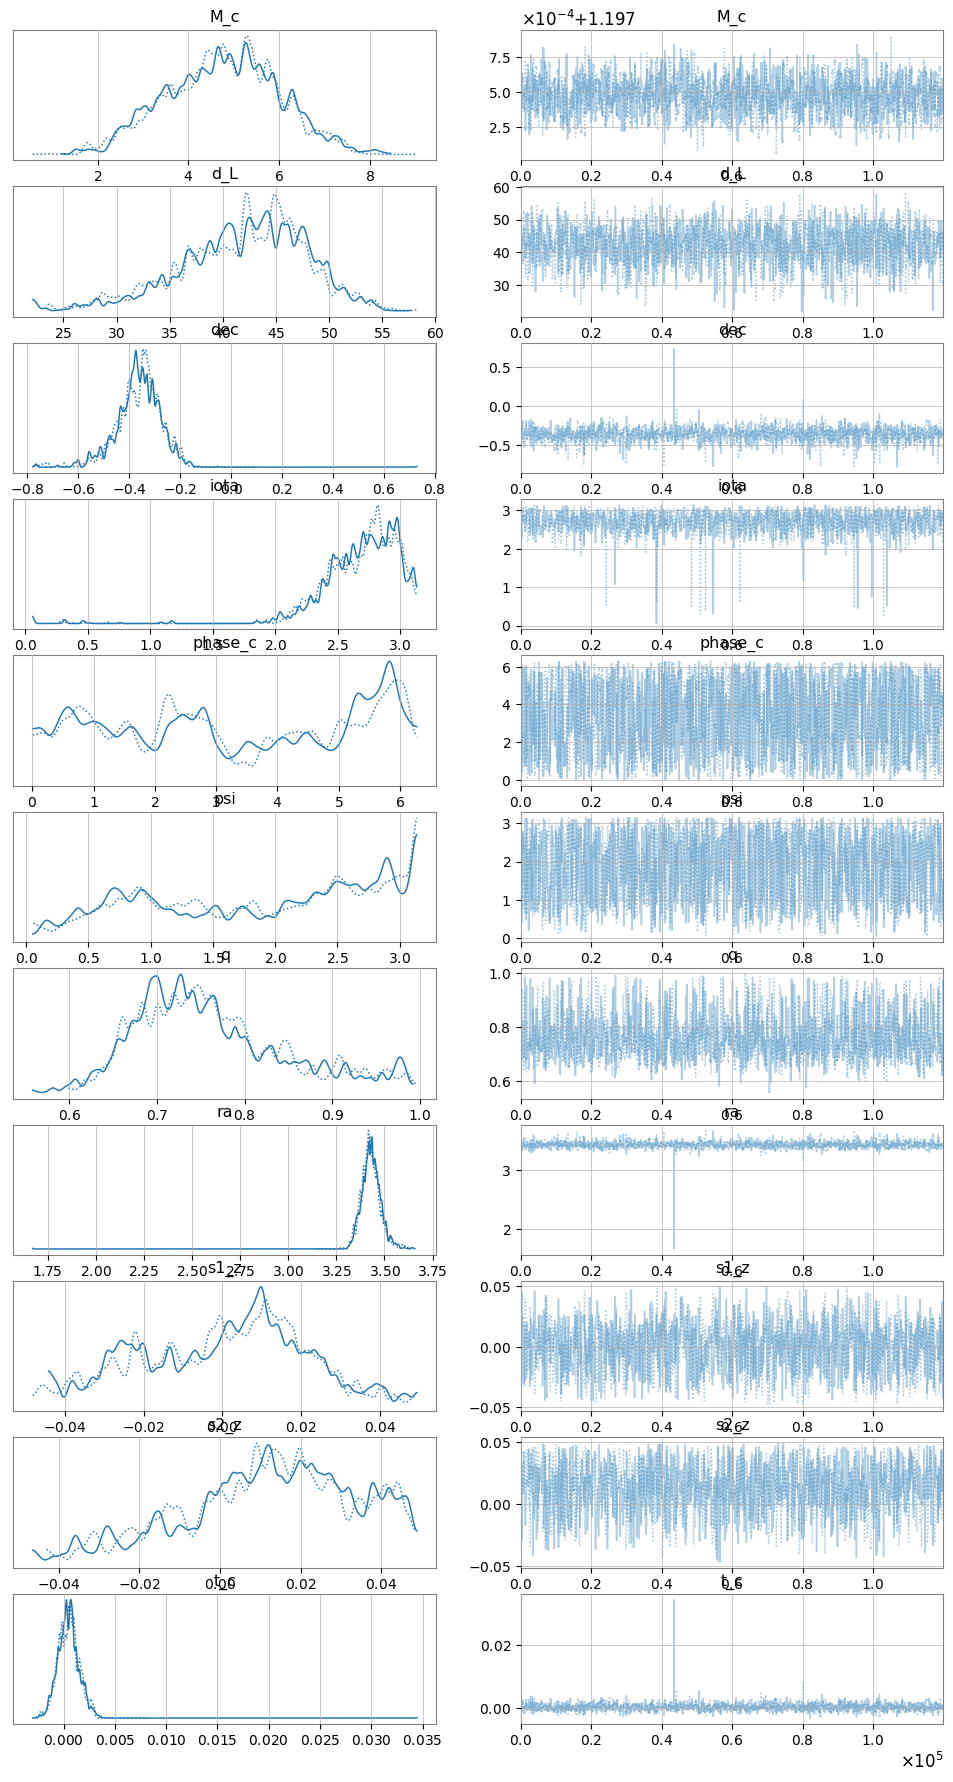

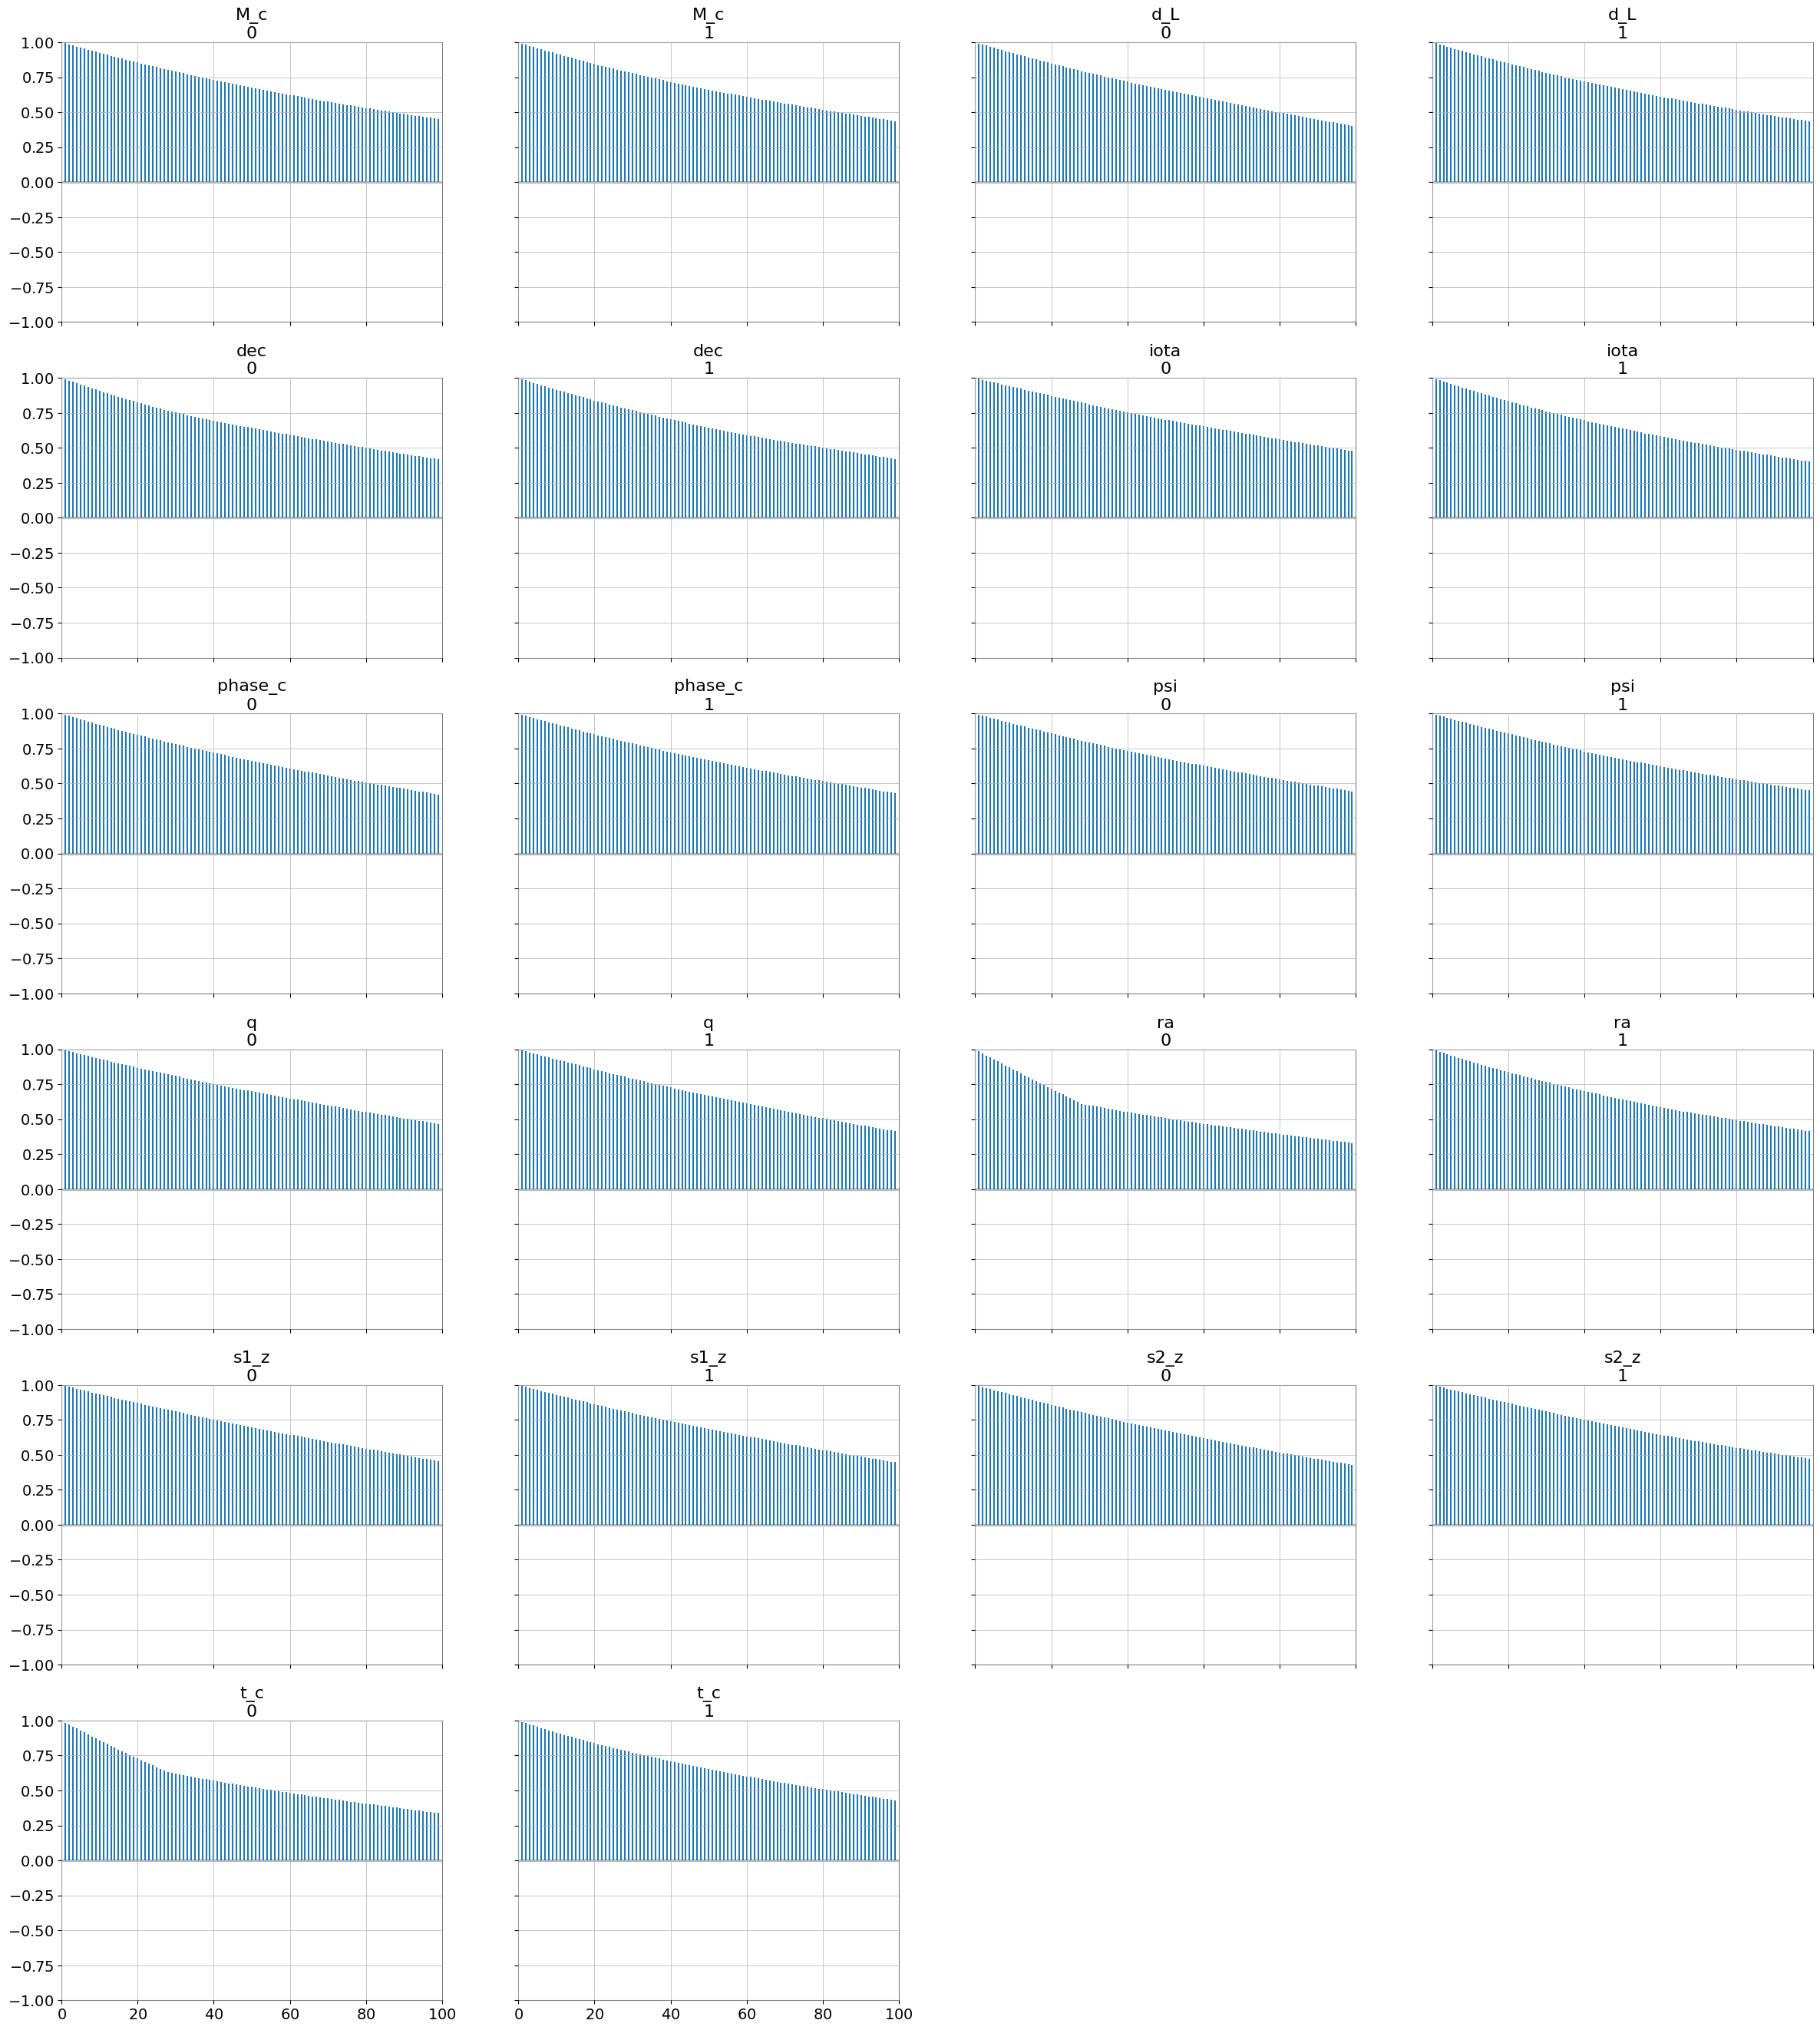

In [20]:
import numpy as np
import arviz as az



# Step 1: Reshape the samples to simulate multiple chains (assuming 2 chains)
# We split the long array into 2 chains. Adjust the shape as needed.
num_chains = 2
num_iterations = len(samples['M_c']) // num_chains  # Total samples / number of chains

samples_reshaped = {param: np.reshape(sample, (num_chains, num_iterations)) for param, sample in samples.items()}

# Step 2: Convert to Arviz InferenceData format
inference_data = az.from_dict(posterior=samples_reshaped)

# Step 3: Calculate Gelman-Rubin (Rhat)
rhat_values = az.rhat(inference_data)
print("Gelman-Rubin (Rhat) Values:\n", rhat_values)

# Step 4: Calculate Effective Sample Size (ESS)
ess_values = az.ess(inference_data)
print("\nEffective Sample Size (ESS):\n", ess_values)

# Optional: Visualize trace and autocorrelation plots
az.plot_trace(inference_data)
az.plot_autocorr(inference_data)


In [21]:
samples

{'M_c': Array([1.19743925, 1.19743925, 1.19743925, ..., 1.19758794,
        1.19758794, 1.19758794], dtype=float64),
 'd_L': Array([46.24301243, 46.24301243, 46.24301243, ..., 30.85848095,
        30.85848095, 30.85848095], dtype=float64),
 'dec': Array([-0.34238338, -0.34238338, -0.34238338, ..., -0.34290053,
        -0.34290053, -0.34290053], dtype=float64),
 'iota': Array([2.91602569, 2.91602569, 2.91602569, ..., 2.19584505,
        2.19584505, 2.19584505], dtype=float64),
 'phase_c': Array([3.79946801, 3.79946801, 3.79946801, ..., 4.12381224,
        4.12381224, 4.12381224], dtype=float64),
 'psi': Array([0.69974031, 0.69974031, 0.69974031, ..., 0.75213062,
        0.75213062, 0.75213062], dtype=float64),
 'q': Array([0.82783292, 0.82783292, 0.82783292, ..., 0.79558694,
        0.79558694, 0.79558694], dtype=float64),
 'ra': Array([3.44325516, 3.44325516, 3.44325516, ..., 3.41849042,
        3.41849042, 3.41849042], dtype=float64),
 's1_z': Array([-0.03984298, -0.03984298, -0.03984